In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import random,shutil

(256, 1600, 3)

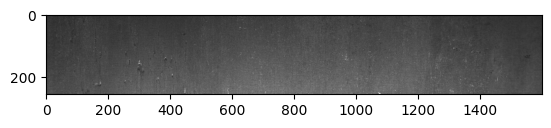

In [3]:
img = cv2.imread('/kaggle/input/severstal-steel-defect-detection/train_images/000a4bcdd.jpg')
plt.imshow(img)
img.shape

In [4]:
df = pd.read_csv('/kaggle/input/severstal-steel-defect-detection/train.csv')

In [5]:
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [6]:
df['ClassId'].unique()

array([1, 3, 4, 2])

In [7]:
a = df.iloc[0]['EncodedPixels']

In [8]:
# 1) RLE → mask
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.array(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    flat = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        flat[lo:hi] = 1
    return flat.reshape(shape, order='F')

# 2) mask → bbox
def mask_to_bbox(mask):
    ys, xs = np.where(mask)
    if len(xs)==0:
        return None
    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()
    return xmin, ymin, xmax, ymax
    
# 3) bbox → YOLO format
def bbox_to_yolo(xmin, ymin, xmax, ymax, img_w, img_h):
    box_w = xmax - xmin
    box_h = ymax - ymin
    x_c = xmin + box_w/2
    y_c = ymin + box_h/2
    return x_c/img_w, y_c/img_h, box_w/img_w, box_h/img_h



In [9]:
img = Image.open('/kaggle/input/severstal-steel-defect-detection/train_images/000a4bcdd.jpg')
img_w,img_h = img.size

In [10]:
k = rle_decode(a,shape=(img_h,img_w))

In [11]:
df = pd.read_csv('/kaggle/input/severstal-steel-defect-detection/train.csv')
image_size = (1600, 256)  # Severstal images are 256×1600 (H×W)

for img_id, group in df.groupby('ImageId'):
    lines = []
    for _, row in group.iterrows():
        cl = int(row.ClassId) - 1
        if pd.isna(row.EncodedPixels):
            continue
        mask = rle_decode(row.EncodedPixels, image_size)
        bbox = mask_to_bbox(mask)
        if bbox is None:
            continue
        yolo_box = bbox_to_yolo(*bbox, img_w=image_size[1], img_h=image_size[0])
        lines.append(f"{cl} " + " ".join(f"{v:.6f}" for v in yolo_box))
    # save if there is at least one defect
    if lines:
        os.makedirs('labels/train', exist_ok=True)
        with open(f"labels/train/{img_id[:-4]}.txt", 'w') as f:
            f.write("\n".join(lines))

In [12]:
len(os.listdir('/kaggle/working/labels/train'))

6666

In [13]:
folders = ['train/images','train/labels','valid/images','valid/labels']
!cd /kaggle/working/
for folder in folders:
    os.makedirs(folder,exist_ok=True)

In [14]:
SRC_IMG_DIR = '/kaggle/input/severstal-steel-defect-detection/train_images'
SRC_LABEL_DIR = '/kaggle/working/labels/train'

# Your existing YOLO structure
YOLO_BASE    = '/kaggle/working'
TRAIN_IMG_DIR = os.path.join(YOLO_BASE, 'train/images')
TRAIN_LBL_DIR = os.path.join(YOLO_BASE, 'train/labels')
VAL_IMG_DIR   = os.path.join(YOLO_BASE, 'valid/images')
VAL_LBL_DIR   = os.path.join(YOLO_BASE, 'valid/labels')

In [15]:
all_imgs = sorted(fname for fname in os.listdir(SRC_IMG_DIR)
                  if fname.lower().endswith(('.jpg','.png','jpeg')))

random.seed(42)
random.shuffle(all_imgs)
split = int(0.8 * len(all_imgs))
train_imgs, valid_imgs = all_imgs[:split], all_imgs[split:]

def distribute(img_list, dst_img_dir, dst_lbl_dir):
    for img in img_list:
        base = os.path.splitext(img)[0]
        # copy image
        shutil.copy(
            os.path.join(SRC_IMG_DIR, img),
            os.path.join(dst_img_dir, img)
        )
        # copy label if exists, else empty file
        src_lbl = os.path.join(SRC_LABEL_DIR, base + '.txt')
        dst_lbl = os.path.join(dst_lbl_dir,   base + '.txt')
        if os.path.exists(src_lbl):
            shutil.copy(src_lbl, dst_lbl)
        else:
            open(dst_lbl, 'w').close()

# 3) Populate folders
distribute(train_imgs, TRAIN_IMG_DIR, TRAIN_LBL_DIR)
distribute(valid_imgs, VAL_IMG_DIR,   VAL_LBL_DIR)

print(f"Done: {len(train_imgs)} train / {len(valid_imgs)} valid images.")   

Done: 10054 train / 2514 valid images.


In [16]:
yaml_content = """\
train: /kaggle/working/train/images
val:   /kaggle/working/valid/images

nc: 4
names:
  0: 1
  1: 2
  2: 3
  3: 4
"""

# Save to steel.yaml in current working directory
yaml_path = 'steel.yaml'
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"Created YAML file at {os.path.abspath(yaml_path)} with content:\n")
print(yaml_content)

Created YAML file at /kaggle/working/steel.yaml with content:

train: /kaggle/working/train/images
val:   /kaggle/working/valid/images

nc: 4
names:
  0: 1
  1: 2
  2: 3
  3: 4



In [17]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3

In [18]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [19]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 83.4MB/s]


In [20]:
# results = model.train(
#     data='steel.yaml',    # path to the YAML we created
#     epochs=50,            # number of epochs
#     imgsz=640,            # image size
#     batch=16,             # batch size
#     # lr=0.01,              # starting learning rate
#     patience=10,          # early stopping patience
#     # project='runs/train', # where to save results
#     # name='steel_yolov8s'  # folder name under runs/train
# )

In [21]:
results = model.train(
    data='steel.yaml',      # our dataset config
    epochs=100,             # more epochs for convergence
    imgsz=640,              # training image size
    batch=16,               # batch size
    patience=20,            # early stopping patience

    # —————— Augmentations ——————
    augment=True,           # enable default augment pipeline
    mosaic=True,            # mix 4 images into one
    mixup=0.5,              # mixup augmentation
    hsv_h=0.015,            # hue augmentation (±1.5%)
    hsv_s=0.7,              # saturation augmentation (±70%)
    hsv_v=0.4,              # value augmentation (±40%)
    degrees=2.0,            # image rotation (±2°)
    translate=0.1,          # image translation (±10%)
    scale=0.5,              # image scale (±50%)
    shear=2.0,              # shear (±2°)
    perspective=0.0,        # perspective transformation
    flipud=0.0,             # vertical flip probability
    fliplr=0.5,             # horizontal flip probability

    # —————— Optimizer & LR schedule ——————
    optimizer='AdamW',      # switch to AdamW for faster convergence
    lr0=0.001,              # initial learning rate
    lrf=0.01,               # final learning rate = lr0 * lrf
    momentum=0.937,         # SGD momentum (not used by AdamW)
    weight_decay=0.0005,    # optimizer weight decay

    # —————— Other training tweaks ——————
    cache=True,             # cache images for faster epoch loops
    workers=4,              # number of dataloader workers
    val=True,               # run validation at each epoch
    # device=0                # GPU id (or '0,1' for multi-GPU)
)

Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=steel.yaml, degrees=2.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.5, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=True, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fa

100%|██████████| 755k/755k [00:00<00:00, 18.3MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 77.0MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1809.3±1033.6 MB/s, size: 119.9 KB)


train: Scanning /kaggle/working/train/labels... 10054 images, 4727 backgrounds, 0 corrupt: 100%|██████████| 10054/10054 [00:05<00:00, 1677.66it/s]


train: New cache created: /kaggle/working/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (1.9GB RAM): 100%|██████████| 10054/10054 [00:13<00:00, 763.55it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1406.1±874.8 MB/s, size: 105.8 KB)


val: Scanning /kaggle/working/valid/labels... 2514 images, 1175 backgrounds, 0 corrupt: 100%|██████████| 2514/2514 [00:01<00:00, 1774.01it/s]


val: New cache created: /kaggle/working/valid/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.5GB RAM): 100%|██████████| 2514/2514 [00:03<00:00, 774.27it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.03G      1.375      2.684      1.421         13        640: 100%|██████████| 629/629 [01:55<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:08<00:00,  8.96it/s]


                   all       2514       1420       0.49       0.27      0.205       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.05G      1.274       2.23      1.337          8        640: 100%|██████████| 629/629 [01:54<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00,  9.99it/s]


                   all       2514       1420      0.521      0.284      0.225      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.07G      1.212       2.08      1.303         10        640: 100%|██████████| 629/629 [01:53<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:08<00:00,  9.66it/s]

                   all       2514       1420      0.497      0.301      0.236       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.08G      1.161       1.97      1.274         10        640: 100%|██████████| 629/629 [01:51<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.08it/s]

                   all       2514       1420      0.342      0.403      0.335      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.1G       1.12      1.882      1.246         15        640: 100%|██████████| 629/629 [01:53<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.27it/s]

                   all       2514       1420      0.403      0.411      0.379       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.11G      1.097      1.809      1.225         17        640: 100%|██████████| 629/629 [01:51<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.04it/s]

                   all       2514       1420      0.609      0.366       0.39      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.13G       1.07      1.749      1.216         14        640: 100%|██████████| 629/629 [01:53<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:08<00:00,  9.74it/s]


                   all       2514       1420       0.37      0.438      0.368      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.15G      1.046        1.7      1.198          9        640: 100%|██████████| 629/629 [01:54<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.03it/s]


                   all       2514       1420      0.407      0.446      0.422      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.17G      1.026      1.666      1.188         13        640: 100%|██████████| 629/629 [01:53<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.02it/s]


                   all       2514       1420      0.446      0.456      0.437      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.18G      1.023       1.64      1.192         12        640: 100%|██████████| 629/629 [01:58<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.00it/s]


                   all       2514       1420      0.452      0.437      0.417      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.21G      1.001      1.619       1.18         14        640: 100%|██████████| 629/629 [01:52<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.05it/s]


                   all       2514       1420      0.442      0.496      0.448      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.22G     0.9959      1.581      1.176          8        640: 100%|██████████| 629/629 [01:54<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:08<00:00,  9.87it/s]

                   all       2514       1420      0.418      0.486      0.421      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.24G      1.001      1.581      1.175         17        640: 100%|██████████| 629/629 [01:53<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.60it/s]

                   all       2514       1420      0.477      0.446      0.444      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.25G     0.9786       1.55      1.159         12        640: 100%|██████████| 629/629 [01:55<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.12it/s]


                   all       2514       1420      0.479       0.54      0.476      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.27G     0.9682      1.538      1.159         11        640: 100%|██████████| 629/629 [01:55<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.30it/s]

                   all       2514       1420      0.514      0.518      0.462      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.29G     0.9663      1.518      1.155          4        640: 100%|██████████| 629/629 [01:52<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:08<00:00,  9.86it/s]

                   all       2514       1420      0.513      0.518      0.494      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.31G     0.9583      1.502      1.155         13        640: 100%|██████████| 629/629 [01:53<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.33it/s]


                   all       2514       1420      0.543      0.529      0.512      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.31G     0.9541      1.482      1.148         12        640: 100%|██████████| 629/629 [01:51<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.23it/s]

                   all       2514       1420      0.527      0.523      0.524      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.34G     0.9363       1.46      1.141         13        640: 100%|██████████| 629/629 [01:56<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.46it/s]

                   all       2514       1420      0.592       0.48      0.531      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.36G     0.9399      1.454      1.143         10        640: 100%|██████████| 629/629 [01:55<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.28it/s]


                   all       2514       1420      0.579      0.539      0.546      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.38G     0.9321      1.454      1.134         10        640: 100%|██████████| 629/629 [01:51<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:08<00:00,  9.75it/s]

                   all       2514       1420      0.479      0.593      0.549      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.38G     0.9125      1.415      1.128         12        640: 100%|██████████| 629/629 [01:53<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.11it/s]

                   all       2514       1420      0.532       0.57      0.531      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.41G     0.9244      1.415      1.128         13        640: 100%|██████████| 629/629 [01:56<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.18it/s]

                   all       2514       1420      0.593      0.552      0.586       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.43G     0.9201      1.422      1.128         18        640: 100%|██████████| 629/629 [01:53<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.15it/s]

                   all       2514       1420      0.547      0.571       0.57      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.44G     0.9066      1.397       1.12          9        640: 100%|██████████| 629/629 [01:52<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.29it/s]


                   all       2514       1420      0.526      0.622      0.588      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.45G     0.8933      1.381      1.117          6        640: 100%|██████████| 629/629 [01:53<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.64it/s]


                   all       2514       1420      0.522      0.615      0.555      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.48G     0.9023      1.374      1.117         15        640: 100%|██████████| 629/629 [01:56<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.47it/s]


                   all       2514       1420       0.58      0.598      0.597      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.49G     0.8916      1.367      1.111         13        640: 100%|██████████| 629/629 [01:53<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:08<00:00,  9.77it/s]

                   all       2514       1420      0.577      0.553      0.573      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.51G     0.8899      1.355      1.113         17        640: 100%|██████████| 629/629 [01:56<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.39it/s]

                   all       2514       1420      0.588      0.617      0.596      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.52G     0.8807      1.346      1.108         10        640: 100%|██████████| 629/629 [01:54<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.50it/s]

                   all       2514       1420      0.564      0.569      0.571      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.54G     0.8816      1.344      1.106         17        640: 100%|██████████| 629/629 [01:56<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.82it/s]

                   all       2514       1420      0.557      0.648      0.588      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.56G     0.8767      1.347      1.107         12        640: 100%|██████████| 629/629 [01:54<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.57it/s]

                   all       2514       1420      0.583      0.583      0.581      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.58G     0.8805      1.329      1.104         17        640: 100%|██████████| 629/629 [01:55<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.54it/s]

                   all       2514       1420      0.623      0.614       0.61      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.59G     0.8797      1.319      1.103          9        640: 100%|██████████| 629/629 [01:53<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.33it/s]

                   all       2514       1420      0.564      0.618      0.607      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.61G     0.8694      1.304      1.097          8        640: 100%|██████████| 629/629 [01:56<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.75it/s]

                   all       2514       1420      0.599      0.611      0.604      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.63G     0.8614      1.297      1.094         12        640: 100%|██████████| 629/629 [01:57<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.45it/s]

                   all       2514       1420      0.568      0.605      0.597      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.64G     0.8731      1.309      1.098         11        640: 100%|██████████| 629/629 [01:56<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.24it/s]

                   all       2514       1420      0.599      0.617       0.61      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.65G     0.8626      1.299      1.093         13        640: 100%|██████████| 629/629 [01:53<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00,  9.96it/s]

                   all       2514       1420      0.548      0.631      0.599      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.68G     0.8606      1.285      1.095          8        640: 100%|██████████| 629/629 [01:56<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.61it/s]


                   all       2514       1420       0.61       0.65      0.631      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       2.7G     0.8548      1.268      1.089         12        640: 100%|██████████| 629/629 [01:56<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.63it/s]

                   all       2514       1420      0.587       0.61      0.623      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.71G     0.8462      1.269      1.083         15        640: 100%|██████████| 629/629 [01:58<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.31it/s]

                   all       2514       1420      0.635      0.587      0.623      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.72G     0.8403       1.24      1.085         15        640: 100%|██████████| 629/629 [01:56<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.18it/s]

                   all       2514       1420      0.578      0.603      0.618      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.75G     0.8379       1.26      1.082          7        640: 100%|██████████| 629/629 [01:57<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.78it/s]

                   all       2514       1420      0.636      0.582      0.642      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.77G     0.8389      1.256      1.079         21        640: 100%|██████████| 629/629 [01:54<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00,  9.96it/s]

                   all       2514       1420      0.614      0.619      0.633      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.78G     0.8267      1.229      1.075         10        640: 100%|██████████| 629/629 [01:55<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.17it/s]

                   all       2514       1420      0.586      0.653       0.63      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.79G     0.8309      1.221      1.075         11        640: 100%|██████████| 629/629 [01:54<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.02it/s]

                   all       2514       1420      0.609      0.626      0.642      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.82G     0.8239       1.22      1.072         13        640: 100%|██████████| 629/629 [01:56<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.44it/s]

                   all       2514       1420      0.611      0.603      0.647       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.83G     0.8248      1.204      1.069         11        640: 100%|██████████| 629/629 [01:55<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.27it/s]

                   all       2514       1420      0.638      0.608      0.649      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.85G     0.8101      1.189      1.065         11        640: 100%|██████████| 629/629 [01:55<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.51it/s]

                   all       2514       1420      0.656      0.626      0.665      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.86G     0.8167      1.181       1.07         10        640: 100%|██████████| 629/629 [01:56<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:08<00:00,  9.84it/s]

                   all       2514       1420      0.636      0.612      0.637      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.88G     0.8192        1.2      1.068         11        640: 100%|██████████| 629/629 [01:58<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.43it/s]

                   all       2514       1420      0.649      0.595      0.646      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       2.9G     0.8111      1.193      1.064         19        640: 100%|██████████| 629/629 [01:54<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.19it/s]

                   all       2514       1420      0.602      0.641      0.642      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.92G     0.8117      1.174      1.064         16        640: 100%|██████████| 629/629 [01:57<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.75it/s]

                   all       2514       1420      0.596      0.639      0.642      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.93G     0.8105       1.17      1.061         12        640: 100%|██████████| 629/629 [01:57<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.45it/s]

                   all       2514       1420      0.579      0.658      0.638      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.95G     0.8089      1.166       1.06         10        640: 100%|██████████| 629/629 [01:57<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.86it/s]

                   all       2514       1420      0.673      0.598      0.647      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.97G      0.798      1.147      1.059          9        640: 100%|██████████| 629/629 [01:56<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.46it/s]

                   all       2514       1420      0.627      0.619      0.636      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.98G     0.8006      1.146      1.061         11        640: 100%|██████████| 629/629 [01:56<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.91it/s]

                   all       2514       1420      0.622      0.625       0.63      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.99G     0.7981      1.138      1.058         12        640: 100%|██████████| 629/629 [01:55<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.50it/s]

                   all       2514       1420      0.624      0.633      0.644      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.02G      0.806       1.14      1.061         16        640: 100%|██████████| 629/629 [02:01<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.83it/s]

                   all       2514       1420      0.601      0.639      0.636       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.04G     0.7929      1.121      1.053          7        640: 100%|██████████| 629/629 [01:54<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.78it/s]

                   all       2514       1420      0.599      0.644      0.631      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.05G     0.7873      1.131      1.057         15        640: 100%|██████████| 629/629 [01:56<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.57it/s]

                   all       2514       1420      0.607      0.649      0.641      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.06G     0.7864      1.128      1.053         10        640: 100%|██████████| 629/629 [01:56<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.51it/s]

                   all       2514       1420      0.622      0.612      0.638      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.09G     0.7779      1.117      1.046          8        640: 100%|██████████| 629/629 [01:56<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.61it/s]

                   all       2514       1420      0.611      0.614      0.642      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       3.1G     0.7819      1.116       1.05         10        640: 100%|██████████| 629/629 [01:56<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.37it/s]

                   all       2514       1420      0.608      0.654      0.641      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.12G     0.7734      1.106      1.045         10        640: 100%|██████████| 629/629 [01:55<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.76it/s]

                   all       2514       1420      0.579      0.649      0.635      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.13G     0.7774      1.088      1.047          9        640: 100%|██████████| 629/629 [01:58<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.65it/s]

                   all       2514       1420      0.581      0.652      0.638      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.16G     0.7733      1.094      1.043          9        640: 100%|██████████| 629/629 [02:00<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.73it/s]

                   all       2514       1420       0.56      0.675      0.642       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.17G     0.7699      1.084      1.042         15        640: 100%|██████████| 629/629 [01:57<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.57it/s]


                   all       2514       1420      0.566      0.667      0.649      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.19G     0.7661      1.083      1.039         17        640: 100%|██████████| 629/629 [01:54<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.55it/s]

                   all       2514       1420      0.568      0.695      0.659      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       3.2G     0.7578      1.075      1.036         17        640: 100%|██████████| 629/629 [01:56<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.77it/s]

                   all       2514       1420      0.589      0.687       0.66       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.22G     0.7676      1.076      1.042         12        640: 100%|██████████| 629/629 [01:53<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.48it/s]

                   all       2514       1420      0.601      0.671      0.657      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.24G     0.7584      1.062      1.036         12        640: 100%|██████████| 629/629 [01:54<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.62it/s]

                   all       2514       1420        0.6      0.659      0.642      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.26G     0.7558      1.064      1.036         15        640: 100%|██████████| 629/629 [01:55<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.54it/s]

                   all       2514       1420      0.626      0.673      0.655      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.27G     0.7587      1.065      1.034         12        640: 100%|██████████| 629/629 [01:55<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.63it/s]

                   all       2514       1420      0.636      0.665      0.661      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.29G     0.7479      1.053      1.031          9        640: 100%|██████████| 629/629 [01:55<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.82it/s]

                   all       2514       1420       0.62      0.654      0.648      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.31G     0.7465      1.034       1.03          8        640: 100%|██████████| 629/629 [01:53<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.77it/s]

                   all       2514       1420      0.619      0.653      0.655      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.33G      0.753      1.035      1.033         18        640: 100%|██████████| 629/629 [01:55<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.78it/s]

                   all       2514       1420       0.61      0.665      0.646      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.33G     0.7395       1.03      1.029         15        640: 100%|██████████| 629/629 [01:59<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 11.03it/s]

                   all       2514       1420      0.612       0.64      0.647      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.36G     0.7428      1.029      1.024         12        640: 100%|██████████| 629/629 [01:52<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.97it/s]

                   all       2514       1420      0.617      0.645      0.657      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.38G     0.7358      1.016      1.023         16        640: 100%|██████████| 629/629 [01:53<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.37it/s]

                   all       2514       1420      0.646       0.61      0.651      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.39G     0.7429      1.022      1.029          6        640: 100%|██████████| 629/629 [01:54<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.82it/s]

                   all       2514       1420      0.637      0.623      0.652      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       3.4G     0.7372      1.021      1.024         13        640: 100%|██████████| 629/629 [01:56<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.96it/s]

                   all       2514       1420      0.638      0.618       0.65      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.43G     0.7343      1.016      1.024         15        640: 100%|██████████| 629/629 [01:58<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.69it/s]

                   all       2514       1420      0.621      0.625       0.65      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.44G      0.716     0.9849      1.014         16        640: 100%|██████████| 629/629 [01:53<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.81it/s]

                   all       2514       1420      0.628      0.635      0.657      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.46G     0.7314     0.9958      1.018          9        640: 100%|██████████| 629/629 [01:55<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.19it/s]

                   all       2514       1420      0.616      0.642      0.655      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.47G     0.7282     0.9946      1.017         12        640: 100%|██████████| 629/629 [01:56<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 11.10it/s]

                   all       2514       1420       0.63      0.641      0.657      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       3.5G     0.7313     0.9948      1.019         16        640: 100%|██████████| 629/629 [01:56<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.93it/s]

                   all       2514       1420      0.611      0.639      0.652      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.51G     0.7195     0.9771      1.012         16        640: 100%|██████████| 629/629 [01:57<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.54it/s]

                   all       2514       1420      0.626      0.647      0.664      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.53G     0.7153      0.974       1.01         14        640: 100%|██████████| 629/629 [01:56<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:07<00:00, 10.68it/s]

                   all       2514       1420      0.625      0.648      0.661      0.432
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 69, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



89 epochs completed in 3.048 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 79/79 [00:09<00:00,  8.30it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2514       1420      0.587      0.684       0.66      0.442
                     1        173        173      0.569      0.769      0.671      0.395
                     2         44         44      0.537      0.409      0.445        0.2
                     3       1052       1052       0.63      0.771      0.773      0.616
                     4        151        151       0.61      0.788       0.75      0.555
Speed: 0.0ms preprocess, 1.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train
